# Task II: Classical Graph Neural Network (GNN) Part

Problem statement: use ParticleNet’s data for Quark/Gluon jet classification[1], then choose 2 Graph-based architectures of your choice to classify jets as being quarks (label = 1) or gluons (label = 0). Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. Discuss the resulting performance of the 2 chosen architectures.
For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.

● Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.

● Discuss the resulting performance of the 2 chosen architectures.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tf_keras_model import get_particle_net_lite, get_particle_net

import logging
logging.basicConfig(level=logging.INFO,
                    format='[%(asctime)s] %(levelname)s: %(message)s')
%matplotlib inline

Because Google Colab has a restricted amount of Memory, this project only used the first 9 files of data from reference [1] (without charm and bottom jets). This is particularly necessary given the restricted amount of time available for the training procedure. Each file contains 100k jets, 50k quark jets and 50k gluon jets, all randomly ordered (label imbalance is not an issue). Every jet in the file comprises $M$ x $F$ data, where $M$ is the maximum multiplicity of the jets in the file and $F$ is the number of characteristics (pt, velocity, azimuthal angle, and pdgid/Particle Data Group ID) for each particle. This project employs 900,000 jets in total.

## Load the dataset

In [3]:
# Load the dataset
# used on colab
!wget https: // zenodo.org/record/3164691/files/QG_jets.npz - P / content/data/

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
dataset = np.load('QG_jets.npz', allow_pickle=True)

In [10]:
# See what keys are present in the dataset
list(dataset.keys())
dataset

In [13]:
import numpy as np
# Load the data
dataset = np.load('./QG_jets.npz')
X = data['X']
y_train = data['y']

# Print the shape of X and y_train
print(f"Shape of X: {X.shape}")
print(f"Shape of y_train: {y_train.shape}")


Shape of X: (100000, 139, 4)
Shape of y_train: (100000,)


<AxesSubplot:ylabel='Count'>

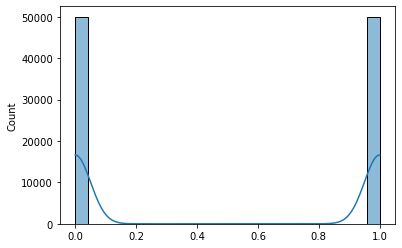

In [14]:
import seaborn as sns

sns.histplot(y_train, kde=True)


In [20]:
X_train = np.array([i[0] for i in X])
print(X_train.shape)

(100000, 4)


In [18]:
# Note: please change the current directory to the correct directory of the .py file if you want to run this code
from tf_keras_model import get_particle_net, get_particle_net_lite
from tf_keras_model_static import get_particle_net_static, get_particle_net_lite_static

## Data preparation
According to the dataset's details (https://zenodo.org/record/3164691#.YigdGt9MHrB),

X: (100000,M,4), precisely 50k quark and 50k gluon jets, randomly ordered, where M is the maximum multiplicity of the jets in that file (other jets have been padded with zero-particles), and each particle's pt, speed, azimuthal angle, and pdgid.

y: (100000,), an array of jet labels where gluon = 0 and quark = 1.

In [23]:
# one hot encoding labels is needed else the following error
# ValueError: Shapes (None, 1) and (None, 2) are incompatible
y = keras.utils.to_categorical(y)
print(y.shape)

(100000, 2)


I faced this error later during training and therefore one hot encoding is performed here.

From the paper on [Jet tagging via particle clouds](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.101.056019)

The first EdgeConv block uses the spatial coordinates of the particles in the pseudorapidity-azimuth space to
compute the distances, while the subsequent blocks use the learned feature vectors as coordinates.

From the dataset we know that the features of each particle are its pt, rapidity, azimuthal angle, and pdgid


In [26]:
x, y = shuffle(x, y, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size=0.5, random_state=42)


# Sanity check
print("Train dataset shape:", x_train.shape, y_train.shape)
print("Val dataset shape:", x_val.shape, y_val.shape)
print("Test dataset shape:", x_test.shape, y_test.shape)

Train dataset shape: (70000, 139, 4) (70000, 2)
Val dataset shape: (15000, 139, 4) (15000, 2)
Test dataset shape: (15000, 139, 4) (15000, 2)


Make a dictionary with the "points," "features," and "mask" arrays for the training, validation, and testing sets.

- "points" simply includes the value of speed and azimuthal angle, which will be used to compute distance for k-NN.
- "features" includes all of the features (pt, speed, azimuthal angle), which will be utilised to train the particle.
- "mask" indicates if the particle is a genuine particle from the dataset or a padded "zero-particles" (taking value of zero for the padded positions).

In [25]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_train = np.sum(x_train, axis=2)
print(mask_train.shape)
print(mask_train[0])

# make the array binary
mask_train = np.array(mask_train != 0, np.float32)
print(mask_train[0])

# reshape mask for a third axis
mask_train = mask_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(mask_train.shape)

(70000, 139)
[   29.20243269    27.50561143    30.26089051   220.41819997
    27.95042087    28.15969933   329.0687446     27.57628735
  -206.06003465   218.08468374    26.41602355    27.02195013
    31.79622486    26.59246689    26.88924931  -202.09822736
    26.71899363    31.23462352  -310.42681747    27.70451205
    30.7169403   -198.56554041  2233.77838649    36.42720615
    29.23621805  -187.38676832    33.46071738   268.17256202
    32.3521241  -2054.01856237   118.7019814     56.63953271
   151.53934524    57.07618763     0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.

In [28]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_val = np.sum(x_val, axis=2)

# make the array binary
mask_val = np.array(mask_val != 0, np.float32)

# reshape mask for a third axis
mask_val = mask_val.reshape(x_val.shape[0], x_val.shape[1], 1)
print(mask_val.shape)

(15000, 139, 1)


In [29]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_test = np.sum(x_test, axis=2)

# make the array binary
mask_test = np.array(mask_test != 0, np.float32)

# reshape mask for a third axis
mask_test = mask_val.reshape(x_test.shape[0], x_test.shape[1], 1)
print(mask_test.shape)

(15000, 139, 1)


We use the implementations from this [github repo](https://github.com/hqucms/ParticleNet) The input is formatted accordingly below for train, val and test

`points` contain rapidity, azimuthal angle used for computing the distance of KNN

`features`: the features of the particles. All the 4 features.

`mask` mask array taking a value of 0 for padded positions.

In [30]:
train_dataset = {
    'points': x_train[:, :, 1:3],
    'features': x_train,
    'mask': mask_train
}

test_dataset = {
    'points': x_test[:, :, 1:3],
    'features': x_test,
    'mask': mask_test
}

val_dataset = {
    'points': x_val[:, :, 1:3],
    'features': x_val,
    'mask': mask_val
}

In [31]:
shapes = {
    'points': x_train[:, :, 1:3].shape[1:],
    'features': x_train.shape[1:],
    'mask': mask_train.shape[1:]
}
shapes

{'points': (139, 2), 'features': (139, 4), 'mask': (139, 1)}

## Particle net lite

In [32]:
# particle net lite
num_classes = 2
model = get_particle_net_lite(num_classes, shapes)

In [33]:
# Training parameters
batch_size = 1024
epochs = 100

In [34]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f' % lr)
    return lr

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2023-03-28 17:34:06,003] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 139, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 139, 1)      0           ['mask[0][0]']                   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 139, 1)       0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.math.equal (TFOpLambda)     (None, 139, 1)       0           ['tf.cast[0][0]']                
                                                                                        

### Train the model

In [36]:
# Prepare model model saving directory.

save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % 'particle_net_lite'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

In [37]:
history = model.fit(train_dataset, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_dataset, y_val),
                    shuffle=True,
                    callbacks=callbacks)

[2023-03-28 17:34:09,488] INFO: Learning rate: 0.001000


Epoch 1/100
      0/Unknown - 294s 0s/sample - loss: 0.5496 - accuracy: 0.7193
Epoch 1: val_accuracy improved from -inf to 0.50967, saving model to model_checkpoints\particle_net_lite_model.001.h5
69/69 [==============================] - 308s 4s/sample - loss: 0.5496 - accuracy: 0.7193 - val_loss: 0.7252 - val_accuracy: 0.5097 - lr: 0.0010


[2023-03-28 17:39:17,044] INFO: Learning rate: 0.001000


Epoch 2/100
 0/69 [..............................] - ETA: 0s - loss: 0.5172 - accuracy: 0.7454
Epoch 2: val_accuracy improved from 0.50967 to 0.56253, saving model to model_checkpoints\particle_net_lite_model.002.h5
69/69 [==============================] - 289s 4s/sample - loss: 0.5172 - accuracy: 0.7454 - val_loss: 0.6673 - val_accuracy: 0.5625 - lr: 0.0010


[2023-03-28 17:44:06,052] INFO: Learning rate: 0.001000


Epoch 3/100
 0/69 [..............................] - ETA: 0s - loss: 0.5096 - accuracy: 0.7509
Epoch 3: val_accuracy improved from 0.56253 to 0.64800, saving model to model_checkpoints\particle_net_lite_model.003.h5
69/69 [==============================] - 281s 4s/sample - loss: 0.5096 - accuracy: 0.7509 - val_loss: 0.6029 - val_accuracy: 0.6480 - lr: 0.0010


[2023-03-28 17:48:47,237] INFO: Learning rate: 0.001000


Epoch 4/100
 0/69 [..............................] - ETA: 0s - loss: 0.5042 - accuracy: 0.7573
Epoch 4: val_accuracy improved from 0.64800 to 0.73233, saving model to model_checkpoints\particle_net_lite_model.004.h5
69/69 [==============================] - 290s 4s/sample - loss: 0.5042 - accuracy: 0.7573 - val_loss: 0.5250 - val_accuracy: 0.7323 - lr: 0.0010


[2023-03-28 17:53:37,611] INFO: Learning rate: 0.001000


Epoch 5/100
 0/69 [..............................] - ETA: 0s - loss: 0.5004 - accuracy: 0.7606
Epoch 5: val_accuracy improved from 0.73233 to 0.75100, saving model to model_checkpoints\particle_net_lite_model.005.h5
69/69 [==============================] - 283s 4s/sample - loss: 0.5004 - accuracy: 0.7606 - val_loss: 0.5088 - val_accuracy: 0.7510 - lr: 0.0010


[2023-03-28 17:58:20,953] INFO: Learning rate: 0.001000


Epoch 6/100
 0/69 [..............................] - ETA: 0s - loss: 0.4991 - accuracy: 0.7616
Epoch 6: val_accuracy improved from 0.75100 to 0.78307, saving model to model_checkpoints\particle_net_lite_model.006.h5
69/69 [==============================] - 276s 4s/sample - loss: 0.4991 - accuracy: 0.7616 - val_loss: 0.4716 - val_accuracy: 0.7831 - lr: 0.0010


[2023-03-28 18:02:56,960] INFO: Learning rate: 0.001000


Epoch 7/100
 0/69 [..............................] - ETA: 0s - loss: 0.4957 - accuracy: 0.7642
Epoch 7: val_accuracy improved from 0.78307 to 0.78633, saving model to model_checkpoints\particle_net_lite_model.007.h5
69/69 [==============================] - 277s 4s/sample - loss: 0.4957 - accuracy: 0.7642 - val_loss: 0.4650 - val_accuracy: 0.7863 - lr: 0.0010


[2023-03-28 18:07:34,386] INFO: Learning rate: 0.001000


Epoch 8/100
 0/69 [..............................] - ETA: 0s - loss: 0.4925 - accuracy: 0.7665
Epoch 8: val_accuracy improved from 0.78633 to 0.79467, saving model to model_checkpoints\particle_net_lite_model.008.h5
69/69 [==============================] - 276s 4s/sample - loss: 0.4925 - accuracy: 0.7665 - val_loss: 0.4631 - val_accuracy: 0.7947 - lr: 0.0010


[2023-03-28 18:12:10,367] INFO: Learning rate: 0.001000


Epoch 9/100
 0/69 [..............................] - ETA: 0s - loss: 0.4899 - accuracy: 0.7697
Epoch 9: val_accuracy improved from 0.79467 to 0.79967, saving model to model_checkpoints\particle_net_lite_model.009.h5
69/69 [==============================] - 277s 4s/sample - loss: 0.4899 - accuracy: 0.7697 - val_loss: 0.4533 - val_accuracy: 0.7997 - lr: 0.0010


[2023-03-28 18:16:47,303] INFO: Learning rate: 0.001000


Epoch 10/100
 0/69 [..............................] - ETA: 0s - loss: 0.4892 - accuracy: 0.7678
Epoch 10: val_accuracy did not improve from 0.79967
69/69 [==============================] - 274s 4s/sample - loss: 0.4892 - accuracy: 0.7678 - val_loss: 0.4630 - val_accuracy: 0.7889 - lr: 0.0010


[2023-03-28 18:21:21,776] INFO: Learning rate: 0.001000


Epoch 11/100
 0/69 [..............................] - ETA: 0s - loss: 0.4882 - accuracy: 0.7688
Epoch 11: val_accuracy did not improve from 0.79967
69/69 [==============================] - 276s 4s/sample - loss: 0.4882 - accuracy: 0.7688 - val_loss: 0.4557 - val_accuracy: 0.7939 - lr: 0.0010


[2023-03-28 18:25:57,937] INFO: Learning rate: 0.000100


Epoch 12/100
 0/69 [..............................] - ETA: 0s - loss: 0.4823 - accuracy: 0.7727
Epoch 12: val_accuracy improved from 0.79967 to 0.80073, saving model to model_checkpoints\particle_net_lite_model.012.h5
69/69 [==============================] - 276s 4s/sample - loss: 0.4823 - accuracy: 0.7727 - val_loss: 0.4489 - val_accuracy: 0.8007 - lr: 1.0000e-04


[2023-03-28 18:30:33,829] INFO: Learning rate: 0.000100


Epoch 13/100
 0/69 [..............................] - ETA: 0s - loss: 0.4811 - accuracy: 0.7740
Epoch 13: val_accuracy did not improve from 0.80073
69/69 [==============================] - 276s 4s/sample - loss: 0.4811 - accuracy: 0.7740 - val_loss: 0.4481 - val_accuracy: 0.7997 - lr: 1.0000e-04


[2023-03-28 18:35:09,668] INFO: Learning rate: 0.000100


Epoch 14/100
 0/69 [..............................] - ETA: 0s - loss: 0.4809 - accuracy: 0.7741
Epoch 14: val_accuracy improved from 0.80073 to 0.80240, saving model to model_checkpoints\particle_net_lite_model.014.h5
69/69 [==============================] - 275s 4s/sample - loss: 0.4809 - accuracy: 0.7741 - val_loss: 0.4476 - val_accuracy: 0.8024 - lr: 1.0000e-04


[2023-03-28 18:39:44,252] INFO: Learning rate: 0.000100


Epoch 15/100
 0/69 [..............................] - ETA: 0s - loss: 0.4805 - accuracy: 0.7743
Epoch 15: val_accuracy did not improve from 0.80240
69/69 [==============================] - 288s 4s/sample - loss: 0.4805 - accuracy: 0.7743 - val_loss: 0.4471 - val_accuracy: 0.8014 - lr: 1.0000e-04


[2023-03-28 18:44:32,072] INFO: Learning rate: 0.000100


Epoch 16/100
 0/69 [..............................] - ETA: 0s - loss: 0.4806 - accuracy: 0.7743
Epoch 16: val_accuracy did not improve from 0.80240
69/69 [==============================] - 283s 4s/sample - loss: 0.4806 - accuracy: 0.7743 - val_loss: 0.4462 - val_accuracy: 0.8016 - lr: 1.0000e-04


[2023-03-28 18:49:14,700] INFO: Learning rate: 0.000100


Epoch 17/100
 0/69 [..............................] - ETA: 0s - loss: 0.4803 - accuracy: 0.7745
Epoch 17: val_accuracy improved from 0.80240 to 0.80373, saving model to model_checkpoints\particle_net_lite_model.017.h5
69/69 [==============================] - 292s 4s/sample - loss: 0.4803 - accuracy: 0.7745 - val_loss: 0.4468 - val_accuracy: 0.8037 - lr: 1.0000e-04


[2023-03-28 18:54:06,795] INFO: Learning rate: 0.000100


Epoch 18/100
 0/69 [..............................] - ETA: 0s - loss: 0.4801 - accuracy: 0.7744
Epoch 18: val_accuracy did not improve from 0.80373
69/69 [==============================] - 324s 5s/sample - loss: 0.4801 - accuracy: 0.7744 - val_loss: 0.4471 - val_accuracy: 0.8015 - lr: 1.0000e-04


[2023-03-28 18:59:30,387] INFO: Learning rate: 0.000100


Epoch 19/100
 0/69 [..............................] - ETA: 0s - loss: 0.4798 - accuracy: 0.7755
Epoch 19: val_accuracy did not improve from 0.80373
69/69 [==============================] - 280s 4s/sample - loss: 0.4798 - accuracy: 0.7755 - val_loss: 0.4464 - val_accuracy: 0.8012 - lr: 1.0000e-04


[2023-03-28 19:04:10,487] INFO: Learning rate: 0.000100


Epoch 20/100
 0/69 [..............................] - ETA: 0s - loss: 0.4798 - accuracy: 0.7753
Epoch 20: val_accuracy did not improve from 0.80373
69/69 [==============================] - 275s 4s/sample - loss: 0.4798 - accuracy: 0.7753 - val_loss: 0.4457 - val_accuracy: 0.8025 - lr: 1.0000e-04


[2023-03-28 19:08:45,142] INFO: Learning rate: 0.000100


Epoch 21/100
 0/69 [..............................] - ETA: 0s - loss: 0.4795 - accuracy: 0.7745
Epoch 21: val_accuracy did not improve from 0.80373
69/69 [==============================] - 273s 4s/sample - loss: 0.4795 - accuracy: 0.7745 - val_loss: 0.4456 - val_accuracy: 0.8013 - lr: 1.0000e-04


[2023-03-28 19:13:17,929] INFO: Learning rate: 0.000100


Epoch 22/100
 0/69 [..............................] - ETA: 0s - loss: 0.4793 - accuracy: 0.7754
Epoch 22: val_accuracy did not improve from 0.80373
69/69 [==============================] - 274s 4s/sample - loss: 0.4793 - accuracy: 0.7754 - val_loss: 0.4449 - val_accuracy: 0.8026 - lr: 1.0000e-04


[2023-03-28 19:17:51,634] INFO: Learning rate: 0.000100


Epoch 23/100
 0/69 [..............................] - ETA: 0s - loss: 0.4789 - accuracy: 0.7746
Epoch 23: val_accuracy did not improve from 0.80373
69/69 [==============================] - 272s 4s/sample - loss: 0.4789 - accuracy: 0.7746 - val_loss: 0.4458 - val_accuracy: 0.8026 - lr: 1.0000e-04


[2023-03-28 19:22:24,056] INFO: Learning rate: 0.000100


Epoch 24/100
 0/69 [..............................] - ETA: 0s - loss: 0.4785 - accuracy: 0.7755
Epoch 24: val_accuracy did not improve from 0.80373
69/69 [==============================] - 275s 4s/sample - loss: 0.4785 - accuracy: 0.7755 - val_loss: 0.4456 - val_accuracy: 0.8027 - lr: 1.0000e-04


[2023-03-28 19:26:58,619] INFO: Learning rate: 0.000100


Epoch 25/100
 0/69 [..............................] - ETA: 0s - loss: 0.4783 - accuracy: 0.7762
Epoch 25: val_accuracy did not improve from 0.80373
69/69 [==============================] - 277s 4s/sample - loss: 0.4783 - accuracy: 0.7762 - val_loss: 0.4441 - val_accuracy: 0.8037 - lr: 1.0000e-04


[2023-03-28 19:31:35,583] INFO: Learning rate: 0.000100


Epoch 26/100
 0/69 [..............................] - ETA: 0s - loss: 0.4781 - accuracy: 0.7759
Epoch 26: val_accuracy did not improve from 0.80373
69/69 [==============================] - 276s 4s/sample - loss: 0.4781 - accuracy: 0.7759 - val_loss: 0.4465 - val_accuracy: 0.8021 - lr: 1.0000e-04


[2023-03-28 19:36:12,051] INFO: Learning rate: 0.000100


Epoch 27/100
 0/69 [..............................] - ETA: 0s - loss: 0.4777 - accuracy: 0.7761
Epoch 27: val_accuracy did not improve from 0.80373
69/69 [==============================] - 275s 4s/sample - loss: 0.4777 - accuracy: 0.7761 - val_loss: 0.4435 - val_accuracy: 0.8036 - lr: 1.0000e-04


[2023-03-28 19:40:46,738] INFO: Learning rate: 0.000100


Epoch 28/100
 0/69 [..............................] - ETA: 0s - loss: 0.4777 - accuracy: 0.7761
Epoch 28: val_accuracy did not improve from 0.80373
69/69 [==============================] - 275s 4s/sample - loss: 0.4777 - accuracy: 0.7761 - val_loss: 0.4441 - val_accuracy: 0.8023 - lr: 1.0000e-04


[2023-03-28 19:45:21,527] INFO: Learning rate: 0.000100


Epoch 29/100
 0/69 [..............................] - ETA: 0s - loss: 0.4776 - accuracy: 0.7754
Epoch 29: val_accuracy improved from 0.80373 to 0.80473, saving model to model_checkpoints\particle_net_lite_model.029.h5
69/69 [==============================] - 274s 4s/sample - loss: 0.4776 - accuracy: 0.7754 - val_loss: 0.4436 - val_accuracy: 0.8047 - lr: 1.0000e-04


[2023-03-28 19:49:55,841] INFO: Learning rate: 0.000100


Epoch 30/100
 0/69 [..............................] - ETA: 0s - loss: 0.4775 - accuracy: 0.7764
Epoch 30: val_accuracy did not improve from 0.80473
69/69 [==============================] - 275s 4s/sample - loss: 0.4775 - accuracy: 0.7764 - val_loss: 0.4447 - val_accuracy: 0.8027 - lr: 1.0000e-04


[2023-03-28 19:54:30,829] INFO: Learning rate: 0.000100


Epoch 31/100
 0/69 [..............................] - ETA: 0s - loss: 0.4771 - accuracy: 0.7765
Epoch 31: val_accuracy did not improve from 0.80473
69/69 [==============================] - 277s 4s/sample - loss: 0.4771 - accuracy: 0.7765 - val_loss: 0.4435 - val_accuracy: 0.8039 - lr: 1.0000e-04


[2023-03-28 19:59:07,542] INFO: Learning rate: 0.000100


Epoch 32/100
 0/69 [..............................] - ETA: 0s - loss: 0.4772 - accuracy: 0.7765
Epoch 32: val_accuracy did not improve from 0.80473
69/69 [==============================] - 276s 4s/sample - loss: 0.4772 - accuracy: 0.7765 - val_loss: 0.4443 - val_accuracy: 0.8043 - lr: 1.0000e-04


[2023-03-28 20:03:43,953] INFO: Learning rate: 0.000100


Epoch 33/100
 0/69 [..............................] - ETA: 0s - loss: 0.4769 - accuracy: 0.7763
Epoch 33: val_accuracy did not improve from 0.80473
69/69 [==============================] - 275s 4s/sample - loss: 0.4769 - accuracy: 0.7763 - val_loss: 0.4441 - val_accuracy: 0.8043 - lr: 1.0000e-04


[2023-03-28 20:08:19,226] INFO: Learning rate: 0.000100


Epoch 34/100
 0/69 [..............................] - ETA: 0s - loss: 0.4770 - accuracy: 0.7769
Epoch 34: val_accuracy did not improve from 0.80473
69/69 [==============================] - 274s 4s/sample - loss: 0.4770 - accuracy: 0.7769 - val_loss: 0.4430 - val_accuracy: 0.8031 - lr: 1.0000e-04


[2023-03-28 20:12:52,921] INFO: Learning rate: 0.000100


Epoch 35/100
 0/69 [..............................] - ETA: 0s - loss: 0.4761 - accuracy: 0.7777
Epoch 35: val_accuracy did not improve from 0.80473
69/69 [==============================] - 274s 4s/sample - loss: 0.4761 - accuracy: 0.7777 - val_loss: 0.4426 - val_accuracy: 0.8037 - lr: 1.0000e-04


[2023-03-28 20:17:27,118] INFO: Learning rate: 0.000100


Epoch 36/100
 0/69 [..............................] - ETA: 0s - loss: 0.4764 - accuracy: 0.7773
Epoch 36: val_accuracy did not improve from 0.80473
69/69 [==============================] - 274s 4s/sample - loss: 0.4764 - accuracy: 0.7773 - val_loss: 0.4436 - val_accuracy: 0.8045 - lr: 1.0000e-04


[2023-03-28 20:22:00,684] INFO: Learning rate: 0.000100


Epoch 37/100
 0/69 [..............................] - ETA: 0s - loss: 0.4759 - accuracy: 0.7768
Epoch 37: val_accuracy did not improve from 0.80473
69/69 [==============================] - 276s 4s/sample - loss: 0.4759 - accuracy: 0.7768 - val_loss: 0.4433 - val_accuracy: 0.8027 - lr: 1.0000e-04


[2023-03-28 20:26:36,973] INFO: Learning rate: 0.000100


Epoch 38/100
 0/69 [..............................] - ETA: 0s - loss: 0.4758 - accuracy: 0.7764
Epoch 38: val_accuracy did not improve from 0.80473
69/69 [==============================] - 275s 4s/sample - loss: 0.4758 - accuracy: 0.7764 - val_loss: 0.4434 - val_accuracy: 0.8043 - lr: 1.0000e-04


[2023-03-28 20:31:12,224] INFO: Learning rate: 0.000100


Epoch 39/100
 0/69 [..............................] - ETA: 0s - loss: 0.4756 - accuracy: 0.7765
Epoch 39: val_accuracy improved from 0.80473 to 0.80480, saving model to model_checkpoints\particle_net_lite_model.039.h5
69/69 [==============================] - 275s 4s/sample - loss: 0.4756 - accuracy: 0.7765 - val_loss: 0.4418 - val_accuracy: 0.8048 - lr: 1.0000e-04


[2023-03-28 20:35:47,370] INFO: Learning rate: 0.000100


Epoch 40/100
 0/69 [..............................] - ETA: 0s - loss: 0.4755 - accuracy: 0.7775
Epoch 40: val_accuracy improved from 0.80480 to 0.80513, saving model to model_checkpoints\particle_net_lite_model.040.h5
69/69 [==============================] - 274s 4s/sample - loss: 0.4755 - accuracy: 0.7775 - val_loss: 0.4420 - val_accuracy: 0.8051 - lr: 1.0000e-04


[2023-03-28 20:40:21,400] INFO: Learning rate: 0.000100


Epoch 41/100
 0/69 [..............................] - ETA: 0s - loss: 0.4753 - accuracy: 0.7777
Epoch 41: val_accuracy did not improve from 0.80513
69/69 [==============================] - 273s 4s/sample - loss: 0.4753 - accuracy: 0.7777 - val_loss: 0.4428 - val_accuracy: 0.8043 - lr: 1.0000e-04


[2023-03-28 20:44:54,871] INFO: Learning rate: 0.000100


Epoch 42/100
 0/69 [..............................] - ETA: 0s - loss: 0.4753 - accuracy: 0.7784
Epoch 42: val_accuracy did not improve from 0.80513
69/69 [==============================] - 275s 4s/sample - loss: 0.4753 - accuracy: 0.7784 - val_loss: 0.4423 - val_accuracy: 0.8043 - lr: 1.0000e-04


[2023-03-28 20:49:29,511] INFO: Learning rate: 0.000100


Epoch 43/100
 0/69 [..............................] - ETA: 0s - loss: 0.4748 - accuracy: 0.7782
Epoch 43: val_accuracy did not improve from 0.80513
69/69 [==============================] - 275s 4s/sample - loss: 0.4748 - accuracy: 0.7782 - val_loss: 0.4446 - val_accuracy: 0.8020 - lr: 1.0000e-04


[2023-03-28 20:54:04,779] INFO: Learning rate: 0.000100


Epoch 44/100
 0/69 [..............................] - ETA: 0s - loss: 0.4747 - accuracy: 0.7779
Epoch 44: val_accuracy did not improve from 0.80513
69/69 [==============================] - 275s 4s/sample - loss: 0.4747 - accuracy: 0.7779 - val_loss: 0.4417 - val_accuracy: 0.8049 - lr: 1.0000e-04


[2023-03-28 20:58:39,893] INFO: Learning rate: 0.000100


Epoch 45/100
 0/69 [..............................] - ETA: 0s - loss: 0.4745 - accuracy: 0.7781
Epoch 45: val_accuracy did not improve from 0.80513
69/69 [==============================] - 276s 4s/sample - loss: 0.4745 - accuracy: 0.7781 - val_loss: 0.4426 - val_accuracy: 0.8040 - lr: 1.0000e-04


[2023-03-28 21:03:15,978] INFO: Learning rate: 0.000100


Epoch 46/100
 0/69 [..............................] - ETA: 0s - loss: 0.4743 - accuracy: 0.7787
Epoch 46: val_accuracy did not improve from 0.80513
69/69 [==============================] - 282s 4s/sample - loss: 0.4743 - accuracy: 0.7787 - val_loss: 0.4423 - val_accuracy: 0.8043 - lr: 1.0000e-04


[2023-03-28 21:07:57,525] INFO: Learning rate: 0.000100


Epoch 47/100
 0/69 [..............................] - ETA: 0s - loss: 0.4744 - accuracy: 0.7782
Epoch 47: val_accuracy improved from 0.80513 to 0.80533, saving model to model_checkpoints\particle_net_lite_model.047.h5
69/69 [==============================] - 280s 4s/sample - loss: 0.4744 - accuracy: 0.7782 - val_loss: 0.4415 - val_accuracy: 0.8053 - lr: 1.0000e-04


[2023-03-28 21:12:37,496] INFO: Learning rate: 0.000100


Epoch 48/100
 0/69 [..............................] - ETA: 0s - loss: 0.4740 - accuracy: 0.7794
Epoch 48: val_accuracy did not improve from 0.80533
69/69 [==============================] - 277s 4s/sample - loss: 0.4740 - accuracy: 0.7794 - val_loss: 0.4418 - val_accuracy: 0.8035 - lr: 1.0000e-04


[2023-03-28 21:17:14,653] INFO: Learning rate: 0.000100


Epoch 49/100
 0/69 [..............................] - ETA: 0s - loss: 0.4735 - accuracy: 0.7785
Epoch 49: val_accuracy did not improve from 0.80533
69/69 [==============================] - 273s 4s/sample - loss: 0.4735 - accuracy: 0.7785 - val_loss: 0.4412 - val_accuracy: 0.8032 - lr: 1.0000e-04


[2023-03-28 21:21:47,558] INFO: Learning rate: 0.000100


Epoch 50/100
 0/69 [..............................] - ETA: 0s - loss: 0.4735 - accuracy: 0.7790
Epoch 50: val_accuracy did not improve from 0.80533
69/69 [==============================] - 280s 4s/sample - loss: 0.4735 - accuracy: 0.7790 - val_loss: 0.4433 - val_accuracy: 0.8046 - lr: 1.0000e-04


[2023-03-28 21:26:27,723] INFO: Learning rate: 0.000100


Epoch 51/100
 0/69 [..............................] - ETA: 0s - loss: 0.4734 - accuracy: 0.7794
Epoch 51: val_accuracy did not improve from 0.80533
69/69 [==============================] - 274s 4s/sample - loss: 0.4734 - accuracy: 0.7794 - val_loss: 0.4413 - val_accuracy: 0.8032 - lr: 1.0000e-04


[2023-03-28 21:31:01,866] INFO: Learning rate: 0.000100


Epoch 52/100
 0/69 [..............................] - ETA: 0s - loss: 0.4731 - accuracy: 0.7805
Epoch 52: val_accuracy did not improve from 0.80533
69/69 [==============================] - 273s 4s/sample - loss: 0.4731 - accuracy: 0.7805 - val_loss: 0.4410 - val_accuracy: 0.8050 - lr: 1.0000e-04


[2023-03-28 21:35:35,055] INFO: Learning rate: 0.000100


Epoch 53/100
 0/69 [..............................] - ETA: 0s - loss: 0.4730 - accuracy: 0.7801
Epoch 53: val_accuracy improved from 0.80533 to 0.80567, saving model to model_checkpoints\particle_net_lite_model.053.h5
69/69 [==============================] - 273s 4s/sample - loss: 0.4730 - accuracy: 0.7801 - val_loss: 0.4421 - val_accuracy: 0.8057 - lr: 1.0000e-04


[2023-03-28 21:40:08,350] INFO: Learning rate: 0.000100


Epoch 54/100
 0/69 [..............................] - ETA: 0s - loss: 0.4728 - accuracy: 0.7798
Epoch 54: val_accuracy did not improve from 0.80567
69/69 [==============================] - 272s 4s/sample - loss: 0.4728 - accuracy: 0.7798 - val_loss: 0.4407 - val_accuracy: 0.8032 - lr: 1.0000e-04


[2023-03-28 21:44:40,151] INFO: Learning rate: 0.000100


Epoch 55/100
 0/69 [..............................] - ETA: 0s - loss: 0.4724 - accuracy: 0.7796
Epoch 55: val_accuracy did not improve from 0.80567
69/69 [==============================] - 278s 4s/sample - loss: 0.4724 - accuracy: 0.7796 - val_loss: 0.4405 - val_accuracy: 0.8048 - lr: 1.0000e-04


[2023-03-28 21:49:18,474] INFO: Learning rate: 0.000100


Epoch 56/100
 0/69 [..............................] - ETA: 0s - loss: 0.4730 - accuracy: 0.7796
Epoch 56: val_accuracy did not improve from 0.80567
69/69 [==============================] - 294s 4s/sample - loss: 0.4730 - accuracy: 0.7796 - val_loss: 0.4411 - val_accuracy: 0.8041 - lr: 1.0000e-04


[2023-03-28 21:54:12,548] INFO: Learning rate: 0.000100


Epoch 57/100
 0/69 [..............................] - ETA: 0s - loss: 0.4724 - accuracy: 0.7806
Epoch 57: val_accuracy improved from 0.80567 to 0.80627, saving model to model_checkpoints\particle_net_lite_model.057.h5
69/69 [==============================] - 276s 4s/sample - loss: 0.4724 - accuracy: 0.7806 - val_loss: 0.4424 - val_accuracy: 0.8063 - lr: 1.0000e-04


[2023-03-28 21:58:48,450] INFO: Learning rate: 0.000100


Epoch 58/100
 0/69 [..............................] - ETA: 0s - loss: 0.4725 - accuracy: 0.7804
Epoch 58: val_accuracy did not improve from 0.80627
69/69 [==============================] - 276s 4s/sample - loss: 0.4725 - accuracy: 0.7804 - val_loss: 0.4426 - val_accuracy: 0.8041 - lr: 1.0000e-04


[2023-03-28 22:03:24,143] INFO: Learning rate: 0.000100


Epoch 59/100
 0/69 [..............................] - ETA: 0s - loss: 0.4723 - accuracy: 0.7800
Epoch 59: val_accuracy did not improve from 0.80627
69/69 [==============================] - 277s 4s/sample - loss: 0.4723 - accuracy: 0.7800 - val_loss: 0.4447 - val_accuracy: 0.8043 - lr: 1.0000e-04


[2023-03-28 22:08:01,504] INFO: Learning rate: 0.000100


Epoch 60/100
 0/69 [..............................] - ETA: 0s - loss: 0.4723 - accuracy: 0.7802
Epoch 60: val_accuracy did not improve from 0.80627
69/69 [==============================] - 275s 4s/sample - loss: 0.4723 - accuracy: 0.7802 - val_loss: 0.4416 - val_accuracy: 0.8041 - lr: 1.0000e-04


[2023-03-28 22:12:36,846] INFO: Learning rate: 0.000100


Epoch 61/100
 0/69 [..............................] - ETA: 0s - loss: 0.4718 - accuracy: 0.7804
Epoch 61: val_accuracy did not improve from 0.80627
69/69 [==============================] - 275s 4s/sample - loss: 0.4718 - accuracy: 0.7804 - val_loss: 0.4402 - val_accuracy: 0.8049 - lr: 1.0000e-04


[2023-03-28 22:17:11,856] INFO: Learning rate: 0.000100


Epoch 62/100
 0/69 [..............................] - ETA: 0s - loss: 0.4719 - accuracy: 0.7805
Epoch 62: val_accuracy did not improve from 0.80627
69/69 [==============================] - 274s 4s/sample - loss: 0.4719 - accuracy: 0.7805 - val_loss: 0.4397 - val_accuracy: 0.8041 - lr: 1.0000e-04


[2023-03-28 22:21:46,193] INFO: Learning rate: 0.000100


Epoch 63/100
 0/69 [..............................] - ETA: 0s - loss: 0.4718 - accuracy: 0.7813
Epoch 63: val_accuracy did not improve from 0.80627
69/69 [==============================] - 276s 4s/sample - loss: 0.4718 - accuracy: 0.7813 - val_loss: 0.4402 - val_accuracy: 0.8045 - lr: 1.0000e-04


[2023-03-28 22:26:21,864] INFO: Learning rate: 0.000100


Epoch 64/100
 0/69 [..............................] - ETA: 0s - loss: 0.4714 - accuracy: 0.7809
Epoch 64: val_accuracy did not improve from 0.80627
69/69 [==============================] - 274s 4s/sample - loss: 0.4714 - accuracy: 0.7809 - val_loss: 0.4416 - val_accuracy: 0.8051 - lr: 1.0000e-04


[2023-03-28 22:30:56,279] INFO: Learning rate: 0.000100


Epoch 65/100
 0/69 [..............................] - ETA: 0s - loss: 0.4712 - accuracy: 0.7809
Epoch 65: val_accuracy improved from 0.80627 to 0.80633, saving model to model_checkpoints\particle_net_lite_model.065.h5
69/69 [==============================] - 301s 4s/sample - loss: 0.4712 - accuracy: 0.7809 - val_loss: 0.4412 - val_accuracy: 0.8063 - lr: 1.0000e-04


[2023-03-28 22:35:57,216] INFO: Learning rate: 0.000100


Epoch 66/100
 0/69 [..............................] - ETA: 0s - loss: 0.4712 - accuracy: 0.7803
Epoch 66: val_accuracy did not improve from 0.80633
69/69 [==============================] - 320s 5s/sample - loss: 0.4712 - accuracy: 0.7803 - val_loss: 0.4411 - val_accuracy: 0.8047 - lr: 1.0000e-04


[2023-03-28 22:41:16,797] INFO: Learning rate: 0.000100


Epoch 67/100
 0/69 [..............................] - ETA: 0s - loss: 0.4709 - accuracy: 0.7813
Epoch 67: val_accuracy did not improve from 0.80633
69/69 [==============================] - 311s 5s/sample - loss: 0.4709 - accuracy: 0.7813 - val_loss: 0.4399 - val_accuracy: 0.8047 - lr: 1.0000e-04


[2023-03-28 22:46:27,404] INFO: Learning rate: 0.000100


Epoch 68/100
 0/69 [..............................] - ETA: 0s - loss: 0.4710 - accuracy: 0.7814
Epoch 68: val_accuracy did not improve from 0.80633
69/69 [==============================] - 299s 4s/sample - loss: 0.4710 - accuracy: 0.7814 - val_loss: 0.4400 - val_accuracy: 0.8050 - lr: 1.0000e-04


[2023-03-28 22:51:26,000] INFO: Learning rate: 0.000100


Epoch 69/100
 0/69 [..............................] - ETA: 0s - loss: 0.4703 - accuracy: 0.7814
Epoch 69: val_accuracy did not improve from 0.80633
69/69 [==============================] - 276s 4s/sample - loss: 0.4703 - accuracy: 0.7814 - val_loss: 0.4416 - val_accuracy: 0.8051 - lr: 1.0000e-04


[2023-03-28 22:56:01,613] INFO: Learning rate: 0.000100


Epoch 70/100
 0/69 [..............................] - ETA: 0s - loss: 0.4704 - accuracy: 0.7815
Epoch 70: val_accuracy did not improve from 0.80633
69/69 [==============================] - 282s 4s/sample - loss: 0.4704 - accuracy: 0.7815 - val_loss: 0.4407 - val_accuracy: 0.8049 - lr: 1.0000e-04


[2023-03-28 23:00:43,271] INFO: Learning rate: 0.000100


Epoch 71/100
 0/69 [..............................] - ETA: 0s - loss: 0.4703 - accuracy: 0.7808
Epoch 71: val_accuracy did not improve from 0.80633
69/69 [==============================] - 285s 4s/sample - loss: 0.4703 - accuracy: 0.7808 - val_loss: 0.4410 - val_accuracy: 0.8060 - lr: 1.0000e-04


[2023-03-28 23:05:28,327] INFO: Learning rate: 0.000100


Epoch 72/100
 0/69 [..............................] - ETA: 0s - loss: 0.4702 - accuracy: 0.7815
Epoch 72: val_accuracy did not improve from 0.80633
69/69 [==============================] - 295s 4s/sample - loss: 0.4702 - accuracy: 0.7815 - val_loss: 0.4403 - val_accuracy: 0.8042 - lr: 1.0000e-04


[2023-03-28 23:10:23,332] INFO: Learning rate: 0.000100


Epoch 73/100
 0/69 [..............................] - ETA: 0s - loss: 0.4701 - accuracy: 0.7826
Epoch 73: val_accuracy did not improve from 0.80633
69/69 [==============================] - 277s 4s/sample - loss: 0.4701 - accuracy: 0.7826 - val_loss: 0.4398 - val_accuracy: 0.8050 - lr: 1.0000e-04


[2023-03-28 23:15:00,754] INFO: Learning rate: 0.000100


Epoch 74/100
 0/69 [..............................] - ETA: 0s - loss: 0.4700 - accuracy: 0.7828
Epoch 74: val_accuracy did not improve from 0.80633
69/69 [==============================] - 271s 4s/sample - loss: 0.4700 - accuracy: 0.7828 - val_loss: 0.4392 - val_accuracy: 0.8051 - lr: 1.0000e-04


[2023-03-28 23:19:31,432] INFO: Learning rate: 0.000100


Epoch 75/100
 0/69 [..............................] - ETA: 0s - loss: 0.4702 - accuracy: 0.7817
Epoch 75: val_accuracy did not improve from 0.80633
69/69 [==============================] - 274s 4s/sample - loss: 0.4702 - accuracy: 0.7817 - val_loss: 0.4399 - val_accuracy: 0.8046 - lr: 1.0000e-04


[2023-03-28 23:24:05,515] INFO: Learning rate: 0.000100


Epoch 76/100
 0/69 [..............................] - ETA: 0s - loss: 0.4699 - accuracy: 0.7822
Epoch 76: val_accuracy did not improve from 0.80633
69/69 [==============================] - 273s 4s/sample - loss: 0.4699 - accuracy: 0.7822 - val_loss: 0.4392 - val_accuracy: 0.8051 - lr: 1.0000e-04


[2023-03-28 23:28:38,717] INFO: Learning rate: 0.000100


Epoch 77/100
 0/69 [..............................] - ETA: 0s - loss: 0.4693 - accuracy: 0.7819
Epoch 77: val_accuracy improved from 0.80633 to 0.80640, saving model to model_checkpoints\particle_net_lite_model.077.h5
69/69 [==============================] - 271s 4s/sample - loss: 0.4693 - accuracy: 0.7819 - val_loss: 0.4423 - val_accuracy: 0.8064 - lr: 1.0000e-04


[2023-03-28 23:33:09,349] INFO: Learning rate: 0.000100


Epoch 78/100
 0/69 [..............................] - ETA: 0s - loss: 0.4692 - accuracy: 0.7817
Epoch 78: val_accuracy did not improve from 0.80640
69/69 [==============================] - 290s 4s/sample - loss: 0.4692 - accuracy: 0.7817 - val_loss: 0.4397 - val_accuracy: 0.8059 - lr: 1.0000e-04


[2023-03-28 23:37:59,482] INFO: Learning rate: 0.000100


Epoch 79/100
 0/69 [..............................] - ETA: 0s - loss: 0.4689 - accuracy: 0.7822
Epoch 79: val_accuracy did not improve from 0.80640
69/69 [==============================] - 305s 4s/sample - loss: 0.4689 - accuracy: 0.7822 - val_loss: 0.4393 - val_accuracy: 0.8049 - lr: 1.0000e-04


[2023-03-28 23:43:04,962] INFO: Learning rate: 0.000100


Epoch 80/100
 0/69 [..............................] - ETA: 0s - loss: 0.4690 - accuracy: 0.7823
Epoch 80: val_accuracy did not improve from 0.80640
69/69 [==============================] - 325s 5s/sample - loss: 0.4690 - accuracy: 0.7823 - val_loss: 0.4405 - val_accuracy: 0.8045 - lr: 1.0000e-04


[2023-03-28 23:48:30,010] INFO: Learning rate: 0.000100


Epoch 81/100
 0/69 [..............................] - ETA: 0s - loss: 0.4687 - accuracy: 0.7832
Epoch 81: val_accuracy improved from 0.80640 to 0.80647, saving model to model_checkpoints\particle_net_lite_model.081.h5
69/69 [==============================] - 315s 5s/sample - loss: 0.4687 - accuracy: 0.7832 - val_loss: 0.4395 - val_accuracy: 0.8065 - lr: 1.0000e-04


[2023-03-28 23:53:45,311] INFO: Learning rate: 0.000100


Epoch 82/100
 0/69 [..............................] - ETA: 0s - loss: 0.4686 - accuracy: 0.7821
Epoch 82: val_accuracy did not improve from 0.80647
69/69 [==============================] - 305s 4s/sample - loss: 0.4686 - accuracy: 0.7821 - val_loss: 0.4396 - val_accuracy: 0.8041 - lr: 1.0000e-04


[2023-03-28 23:58:50,585] INFO: Learning rate: 0.000100


Epoch 83/100
 0/69 [..............................] - ETA: 0s - loss: 0.4688 - accuracy: 0.7828
Epoch 83: val_accuracy did not improve from 0.80647
69/69 [==============================] - 311s 5s/sample - loss: 0.4688 - accuracy: 0.7828 - val_loss: 0.4402 - val_accuracy: 0.8054 - lr: 1.0000e-04


[2023-03-29 00:04:02,081] INFO: Learning rate: 0.000100


Epoch 84/100
 0/69 [..............................] - ETA: 0s - loss: 0.4684 - accuracy: 0.7820
Epoch 84: val_accuracy improved from 0.80647 to 0.80707, saving model to model_checkpoints\particle_net_lite_model.084.h5
69/69 [==============================] - 312s 5s/sample - loss: 0.4684 - accuracy: 0.7820 - val_loss: 0.4402 - val_accuracy: 0.8071 - lr: 1.0000e-04


[2023-03-29 00:09:13,791] INFO: Learning rate: 0.000100


Epoch 85/100
 0/69 [..............................] - ETA: 0s - loss: 0.4682 - accuracy: 0.7827
Epoch 85: val_accuracy improved from 0.80707 to 0.80713, saving model to model_checkpoints\particle_net_lite_model.085.h5
69/69 [==============================] - 325s 5s/sample - loss: 0.4682 - accuracy: 0.7827 - val_loss: 0.4409 - val_accuracy: 0.8071 - lr: 1.0000e-04


[2023-03-29 00:14:39,154] INFO: Learning rate: 0.000100


Epoch 86/100
 0/69 [..............................] - ETA: 0s - loss: 0.4685 - accuracy: 0.7835
Epoch 86: val_accuracy did not improve from 0.80713
69/69 [==============================] - 326s 5s/sample - loss: 0.4685 - accuracy: 0.7835 - val_loss: 0.4393 - val_accuracy: 0.8049 - lr: 1.0000e-04


[2023-03-29 00:20:05,018] INFO: Learning rate: 0.000100


Epoch 87/100
 0/69 [..............................] - ETA: 0s - loss: 0.4686 - accuracy: 0.7832
Epoch 87: val_accuracy did not improve from 0.80713
69/69 [==============================] - 320s 5s/sample - loss: 0.4686 - accuracy: 0.7832 - val_loss: 0.4386 - val_accuracy: 0.8055 - lr: 1.0000e-04


[2023-03-29 00:25:25,487] INFO: Learning rate: 0.000100


Epoch 88/100
 0/69 [..............................] - ETA: 0s - loss: 0.4678 - accuracy: 0.7831
Epoch 88: val_accuracy did not improve from 0.80713
69/69 [==============================] - 303s 4s/sample - loss: 0.4678 - accuracy: 0.7831 - val_loss: 0.4383 - val_accuracy: 0.8066 - lr: 1.0000e-04


[2023-03-29 00:30:28,387] INFO: Learning rate: 0.000100


Epoch 89/100
 0/69 [..............................] - ETA: 0s - loss: 0.4682 - accuracy: 0.7834
Epoch 89: val_accuracy did not improve from 0.80713
69/69 [==============================] - 331s 5s/sample - loss: 0.4682 - accuracy: 0.7834 - val_loss: 0.4383 - val_accuracy: 0.8048 - lr: 1.0000e-04


[2023-03-29 00:35:59,118] INFO: Learning rate: 0.000100


Epoch 90/100
 0/69 [..............................] - ETA: 0s - loss: 0.4675 - accuracy: 0.7838
Epoch 90: val_accuracy did not improve from 0.80713
69/69 [==============================] - 332s 5s/sample - loss: 0.4675 - accuracy: 0.7838 - val_loss: 0.4392 - val_accuracy: 0.8055 - lr: 1.0000e-04


[2023-03-29 00:41:31,134] INFO: Learning rate: 0.000100


Epoch 91/100
 0/69 [..............................] - ETA: 0s - loss: 0.4676 - accuracy: 0.7825
Epoch 91: val_accuracy did not improve from 0.80713
69/69 [==============================] - 309s 4s/sample - loss: 0.4676 - accuracy: 0.7825 - val_loss: 0.4411 - val_accuracy: 0.8049 - lr: 1.0000e-04


[2023-03-29 00:46:40,153] INFO: Learning rate: 0.000100


Epoch 92/100
 0/69 [..............................] - ETA: 0s - loss: 0.4672 - accuracy: 0.7839
Epoch 92: val_accuracy did not improve from 0.80713
69/69 [==============================] - 312s 5s/sample - loss: 0.4672 - accuracy: 0.7839 - val_loss: 0.4392 - val_accuracy: 0.8042 - lr: 1.0000e-04


[2023-03-29 00:51:52,418] INFO: Learning rate: 0.000100


Epoch 93/100
 0/69 [..............................] - ETA: 0s - loss: 0.4674 - accuracy: 0.7834
Epoch 93: val_accuracy did not improve from 0.80713
69/69 [==============================] - 277s 4s/sample - loss: 0.4674 - accuracy: 0.7834 - val_loss: 0.4420 - val_accuracy: 0.8055 - lr: 1.0000e-04


[2023-03-29 00:56:29,106] INFO: Learning rate: 0.000100


Epoch 94/100
 0/69 [..............................] - ETA: 0s - loss: 0.4673 - accuracy: 0.7833
Epoch 94: val_accuracy did not improve from 0.80713
69/69 [==============================] - 300s 4s/sample - loss: 0.4673 - accuracy: 0.7833 - val_loss: 0.4387 - val_accuracy: 0.8053 - lr: 1.0000e-04


[2023-03-29 01:01:28,921] INFO: Learning rate: 0.000100


Epoch 95/100
 0/69 [..............................] - ETA: 0s - loss: 0.4671 - accuracy: 0.7837
Epoch 95: val_accuracy did not improve from 0.80713
69/69 [==============================] - 310s 4s/sample - loss: 0.4671 - accuracy: 0.7837 - val_loss: 0.4417 - val_accuracy: 0.8037 - lr: 1.0000e-04


[2023-03-29 01:06:39,303] INFO: Learning rate: 0.000100


Epoch 96/100
 0/69 [..............................] - ETA: 0s - loss: 0.4665 - accuracy: 0.7841
Epoch 96: val_accuracy did not improve from 0.80713
69/69 [==============================] - 324s 5s/sample - loss: 0.4665 - accuracy: 0.7841 - val_loss: 0.4419 - val_accuracy: 0.8025 - lr: 1.0000e-04


[2023-03-29 01:12:03,529] INFO: Learning rate: 0.000100


Epoch 97/100
 0/69 [..............................] - ETA: 0s - loss: 0.4668 - accuracy: 0.7835
Epoch 97: val_accuracy did not improve from 0.80713
69/69 [==============================] - 312s 5s/sample - loss: 0.4668 - accuracy: 0.7835 - val_loss: 0.4395 - val_accuracy: 0.8065 - lr: 1.0000e-04


[2023-03-29 01:17:15,978] INFO: Learning rate: 0.000100


Epoch 98/100
 0/69 [..............................] - ETA: 0s - loss: 0.4668 - accuracy: 0.7838
Epoch 98: val_accuracy improved from 0.80713 to 0.80767, saving model to model_checkpoints\particle_net_lite_model.098.h5
69/69 [==============================] - 305s 4s/sample - loss: 0.4668 - accuracy: 0.7838 - val_loss: 0.4398 - val_accuracy: 0.8077 - lr: 1.0000e-04


[2023-03-29 01:22:20,658] INFO: Learning rate: 0.000100


Epoch 99/100
 0/69 [..............................] - ETA: 0s - loss: 0.4662 - accuracy: 0.7838
Epoch 99: val_accuracy did not improve from 0.80767
69/69 [==============================] - 294s 4s/sample - loss: 0.4662 - accuracy: 0.7838 - val_loss: 0.4399 - val_accuracy: 0.8047 - lr: 1.0000e-04


[2023-03-29 01:27:14,868] INFO: Learning rate: 0.000100


Epoch 100/100
 0/69 [..............................] - ETA: 0s - loss: 0.4664 - accuracy: 0.7836
Epoch 100: val_accuracy did not improve from 0.80767
69/69 [==============================] - 297s 4s/sample - loss: 0.4664 - accuracy: 0.7836 - val_loss: 0.4400 - val_accuracy: 0.8077 - lr: 1.0000e-04


In [38]:
import json
with open("particle_net_lite_history.json", "w") as outfile:
    outfile.write(str(history.history))

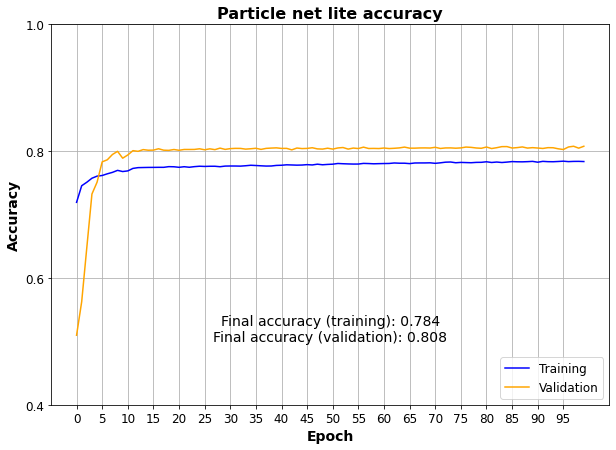

In [41]:
import matplotlib.pyplot as plt

# plot training and validation accuracy with blue and orange lines
plt.plot(history.history['accuracy'], color='blue', label='Training')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation')

# set plot title and axis labels with custom font size and weight
plt.title('Particle net lite accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')

# add grid lines and set figure size
plt.grid(True)
plt.gcf().set_size_inches(10, 7)

# add legend with custom font size and weight
plt.legend(fontsize=12, loc='lower right')

# add text annotation with the final accuracy values of training and validation
final_acc_train = round(history.history['accuracy'][-1], 3)
final_acc_val = round(history.history['val_accuracy'][-1], 3)
plt.text(0.5, 0.2, f'Final accuracy (training): {final_acc_train}\nFinal accuracy (validation): {final_acc_val}',
         fontsize=14, ha='center', va='center', transform=plt.gca().transAxes)

# customize x and y axis ticks and tick labels
plt.xticks(range(0, len(history.history['accuracy']), 5))
plt.yticks([0.4, 0.6, 0.8, 1.0])
plt.tick_params(axis='both', which='major', labelsize=12)

# show plot
plt.show()


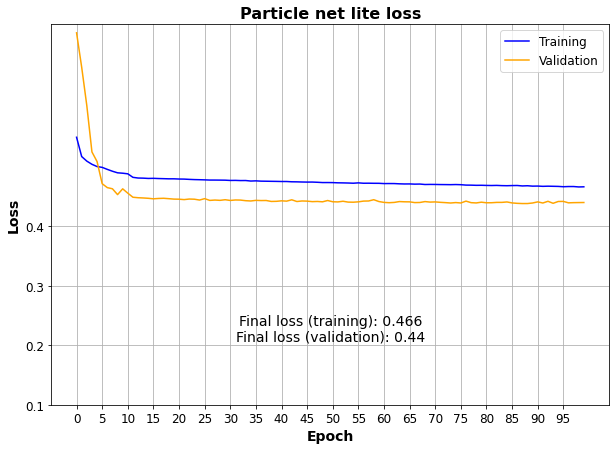

In [44]:
import matplotlib.pyplot as plt

# plot training and validation loss with blue and orange lines
plt.plot(history.history['loss'], color='blue', label='Training')
plt.plot(history.history['val_loss'], color='orange', label='Validation')

# set plot title and axis labels with custom font size and weight
plt.title('Particle net lite loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')

# add grid lines and set figure size
plt.grid(True)
plt.gcf().set_size_inches(10, 7)

# add legend with custom font size and weight
plt.legend(fontsize=12, loc='upper right')

# add text annotation with the final loss values of training and validation
final_loss_train = round(history.history['loss'][-1], 3)
final_loss_val = round(history.history['val_loss'][-1], 3)
plt.text(0.5, 0.2, f'Final loss (training): {final_loss_train}\nFinal loss (validation): {final_loss_val}',
         fontsize=14, ha='center', va='center', transform=plt.gca().transAxes)

# customize x and y axis ticks and tick labels
plt.xticks(range(0, len(history.history['loss']), 5))
plt.yticks([0.1, 0.2, 0.3, 0.4])
plt.tick_params(axis='both', which='major', labelsize=12)

# show plot
plt.show()


### Evaluation

In [43]:
res = model.evaluate(test_dataset, y_test)

469/469 [==============================] - 11s 24ms/step - loss: 0.4794 - accuracy: 0.7788


In [45]:
print("test loss, test acc:", res)

test loss, test acc: [0.479432612657547, 0.7788000106811523]


## Finally,

We used Tensorflow to create a traditional GNN. When looking at the charts for particle net light, the training loss lowers across epochs, as does the training accuracy, indicating that the model matches the data. Nevertheless, at about the 20th epoch, the validation loss and accuracy become constant, indicating overfitting. The training accuracy is close to 82%, which is consistent with the findings of the work [Jet tagging using particle clouds](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.101.056019). Their percentage is 82.6%. One thing to keep in mind is that training the model for 10000 data samples takes a substantial amount of time.

In [51]:
train_dict=train_dataset


In [52]:
model_type = 'particle_net_lite_static'
num_classes = 2
input_shapes = {k:train_dict[k].shape[1:] for k in train_dict}

if 'lite' in model_type:
    model_static = get_particle_net_lite_static(num_classes, input_shapes)
else:
    model_static = get_particle_net_static(num_classes, input_shapes)

print("Input shapes:", input_shapes)

Input shapes: {'points': (139, 2), 'features': (139, 4), 'mask': (139, 1)}


In [53]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 20

In [54]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [56]:
import tensorflow as tf

In [57]:
model_static.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy', tf.keras.metrics.AUC()])
model_static.summary()

[2023-03-29 02:11:16,180] INFO: Learning rate: 0.001000


Model: "ParticleNet_Lite_Static"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 139, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal_1 (TFOpLambd  (None, 139, 1)      0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_2 (TFOpLambda)         (None, 139, 1)       0           ['tf.math.not_equal_1[0][0]']    
                                                                                                  
 tf.math.equal_1 (TFOpLambda)   (None, 139, 1)       0           ['tf.cast_2

In [58]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [lr_scheduler, progress_bar]

In [61]:
history_sgcnn = model_static.fit(train_dict, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_dataset, y_val),
          shuffle=True,
          callbacks=callbacks)

[2023-03-29 02:13:00,555] INFO: Learning rate: 0.001000


Epoch 1/20
69/69 [==============================] - 326s 5s/sample - loss: 0.5436 - accuracy: 0.7269 - auc: 0.7988 - val_loss: 0.7886 - val_accuracy: 0.5072 - val_auc: 0.6717 - lr: 0.0010


[2023-03-29 02:18:26,788] INFO: Learning rate: 0.001000


Epoch 2/20
69/69 [==============================] - 298s 4s/sample - loss: 0.5149 - accuracy: 0.7459 - auc: 0.8245 - val_loss: 0.6003 - val_accuracy: 0.6574 - val_auc: 0.7477 - lr: 0.0010


[2023-03-29 02:23:24,594] INFO: Learning rate: 0.001000


Epoch 3/20
69/69 [==============================] - 281s 4s/sample - loss: 0.5067 - accuracy: 0.7549 - auc: 0.8315 - val_loss: 0.5402 - val_accuracy: 0.7164 - val_auc: 0.8020 - lr: 0.0010


[2023-03-29 02:28:05,752] INFO: Learning rate: 0.001000


Epoch 4/20
69/69 [==============================] - 284s 4s/sample - loss: 0.5014 - accuracy: 0.7596 - auc: 0.8358 - val_loss: 0.4865 - val_accuracy: 0.7701 - val_auc: 0.8470 - lr: 0.0010


[2023-03-29 02:32:49,330] INFO: Learning rate: 0.001000


Epoch 5/20
69/69 [==============================] - 285s 4s/sample - loss: 0.4977 - accuracy: 0.7638 - auc: 0.8390 - val_loss: 0.4606 - val_accuracy: 0.7935 - val_auc: 0.8658 - lr: 0.0010


[2023-03-29 02:37:34,761] INFO: Learning rate: 0.001000


Epoch 6/20
69/69 [==============================] - 290s 4s/sample - loss: 0.4935 - accuracy: 0.7671 - auc: 0.8419 - val_loss: 0.4619 - val_accuracy: 0.7907 - val_auc: 0.8645 - lr: 0.0010


[2023-03-29 02:42:24,775] INFO: Learning rate: 0.001000


Epoch 7/20
69/69 [==============================] - 289s 4s/sample - loss: 0.4903 - accuracy: 0.7691 - auc: 0.8442 - val_loss: 0.4600 - val_accuracy: 0.7977 - val_auc: 0.8676 - lr: 0.0010


[2023-03-29 02:47:13,339] INFO: Learning rate: 0.001000


Epoch 8/20
69/69 [==============================] - 288s 4s/sample - loss: 0.4898 - accuracy: 0.7702 - auc: 0.8445 - val_loss: 0.4485 - val_accuracy: 0.8042 - val_auc: 0.8732 - lr: 0.0010


[2023-03-29 02:52:01,356] INFO: Learning rate: 0.001000


Epoch 9/20
69/69 [==============================] - 286s 4s/sample - loss: 0.4867 - accuracy: 0.7722 - auc: 0.8466 - val_loss: 0.4484 - val_accuracy: 0.8021 - val_auc: 0.8737 - lr: 0.0010


[2023-03-29 02:56:47,440] INFO: Learning rate: 0.001000


Epoch 10/20
69/69 [==============================] - 291s 4s/sample - loss: 0.4863 - accuracy: 0.7720 - auc: 0.8469 - val_loss: 0.4453 - val_accuracy: 0.8054 - val_auc: 0.8757 - lr: 0.0010


[2023-03-29 03:01:38,603] INFO: Learning rate: 0.001000


Epoch 11/20
69/69 [==============================] - 287s 4s/sample - loss: 0.4834 - accuracy: 0.7728 - auc: 0.8489 - val_loss: 0.4402 - val_accuracy: 0.8087 - val_auc: 0.8786 - lr: 0.0010


[2023-03-29 03:06:25,492] INFO: Learning rate: 0.000100


Epoch 12/20
69/69 [==============================] - 292s 4s/sample - loss: 0.4798 - accuracy: 0.7760 - auc: 0.8516 - val_loss: 0.4417 - val_accuracy: 0.8055 - val_auc: 0.8771 - lr: 1.0000e-04


[2023-03-29 03:11:17,898] INFO: Learning rate: 0.000100


Epoch 13/20
69/69 [==============================] - 294s 4s/sample - loss: 0.4784 - accuracy: 0.7762 - auc: 0.8523 - val_loss: 0.4387 - val_accuracy: 0.8068 - val_auc: 0.8788 - lr: 1.0000e-04


[2023-03-29 03:16:11,578] INFO: Learning rate: 0.000100


Epoch 14/20
69/69 [==============================] - 291s 4s/sample - loss: 0.4782 - accuracy: 0.7766 - auc: 0.8525 - val_loss: 0.4381 - val_accuracy: 0.8080 - val_auc: 0.8792 - lr: 1.0000e-04


[2023-03-29 03:21:02,233] INFO: Learning rate: 0.000100


Epoch 15/20
69/69 [==============================] - 312s 5s/sample - loss: 0.4779 - accuracy: 0.7759 - auc: 0.8527 - val_loss: 0.4375 - val_accuracy: 0.8080 - val_auc: 0.8795 - lr: 1.0000e-04


[2023-03-29 03:26:14,501] INFO: Learning rate: 0.000100


Epoch 16/20
69/69 [==============================] - 289s 4s/sample - loss: 0.4780 - accuracy: 0.7764 - auc: 0.8527 - val_loss: 0.4369 - val_accuracy: 0.8087 - val_auc: 0.8799 - lr: 1.0000e-04


[2023-03-29 03:31:03,411] INFO: Learning rate: 0.000100


Epoch 17/20
69/69 [==============================] - 290s 4s/sample - loss: 0.4775 - accuracy: 0.7771 - auc: 0.8530 - val_loss: 0.4384 - val_accuracy: 0.8073 - val_auc: 0.8789 - lr: 1.0000e-04


[2023-03-29 03:35:53,434] INFO: Learning rate: 0.000100


Epoch 18/20
69/69 [==============================] - 326s 5s/sample - loss: 0.4773 - accuracy: 0.7769 - auc: 0.8531 - val_loss: 0.4414 - val_accuracy: 0.8039 - val_auc: 0.8773 - lr: 1.0000e-04


[2023-03-29 03:41:19,320] INFO: Learning rate: 0.000100


Epoch 19/20
69/69 [==============================] - 332s 5s/sample - loss: 0.4771 - accuracy: 0.7768 - auc: 0.8533 - val_loss: 0.4362 - val_accuracy: 0.8091 - val_auc: 0.8803 - lr: 1.0000e-04


[2023-03-29 03:46:51,753] INFO: Learning rate: 0.000100


Epoch 20/20
69/69 [==============================] - 333s 5s/sample - loss: 0.4769 - accuracy: 0.7776 - auc: 0.8534 - val_loss: 0.4364 - val_accuracy: 0.8095 - val_auc: 0.8803 - lr: 1.0000e-04
